# **Greek Parliament Proceedings**


> Eric Tzimas <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />


 

## **Data Exploration**


* Importing necessary modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from matplotlib import pyplot as plt



* **Reading the dataset from** https://zenodo.org

In [2]:
speechs = pd.read_csv('https://zenodo.org/record/2587904/files/Greek_Parliament_Proceedings_1989_2019.csv.zip')
speechs.shape

(1194407, 8)

* Searching for null values and removing them
* Isolating `political_party` and `speech` columns

In [3]:
speechs.isnull().sum()

member_name               47289
sitting_date                  0
parliamentary_period          0
parliamentary_session         0
parliamentary_sitting         0
political_party             162
speaker_info             543871
speech                       10
dtype: int64

In [4]:
sp = pd.DataFrame()
sp['political_party'] = speechs['political_party']
sp['speech'] = speechs['speech']
speech = sp
speech = speech.dropna()
speech.isnull().sum()

political_party    0
speech             0
dtype: int64

* Sampling some of the texts.

In [5]:
speech.sample(10)

,political_party,speech
128790,νεα δημοκρατια,Δηλαδή τα π.δ. είναι αντισυνταγματικά;
505385,νεα δημοκρατια,Θα σας τα πω τώρα.
113717,συνασπισμος της αριστερας των κινηματων και τη...,"Συμφωνούμε και μεις, κύριε Πρόεδρε, με τις 5 ..."
1057520,ενωση κεντρωων,Αυτό καταγγέλλουμε ως Ένωση Κεντρώων από την ...
131353,πανελληνιο σοσιαλιστικο κινημα,"Κύριε Πρόεδρε, μου επιτρέπετε; Θέλω να πω κάτ..."
1115337,ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατ...,Έχουμε την ίδια περίοδο -και θα κλείσω με αυτ...
474961,πανελληνιο σοσιαλιστικο κινημα,"Φοβάμαι, κύριε Πρόεδρε, ότι θα επαναλάβω αυτά..."
617122,νεα δημοκρατια,Δύο δισεκατομμύρια ευρώ πέφτουν στην πόλη.
937585,δημοκρατικη αριστερα,"Ευχαριστώ πολύ, κύριε Πρόεδρε.Νόμιζα, κύριε Υ..."
197658,νεα δημοκρατια,Κάθε φορά τα ίδια λέτε για την υπέρβαση.


* Counting the number of unique political parties in our dataset.

In [6]:
speech['political_party'].unique().shape

(23,)

* Creating a new dataframe for visualisation purposes. 
The dataframe speechs is going to be the same as speech but we will add an extra column that will represent only the year the speech took place in.

In [7]:
speechs['year'] = pd.DatetimeIndex(speechs['sitting_date']).year
speech['year'] = speechs['year']


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


* **Lets plot the number of speeches per year per political_party**

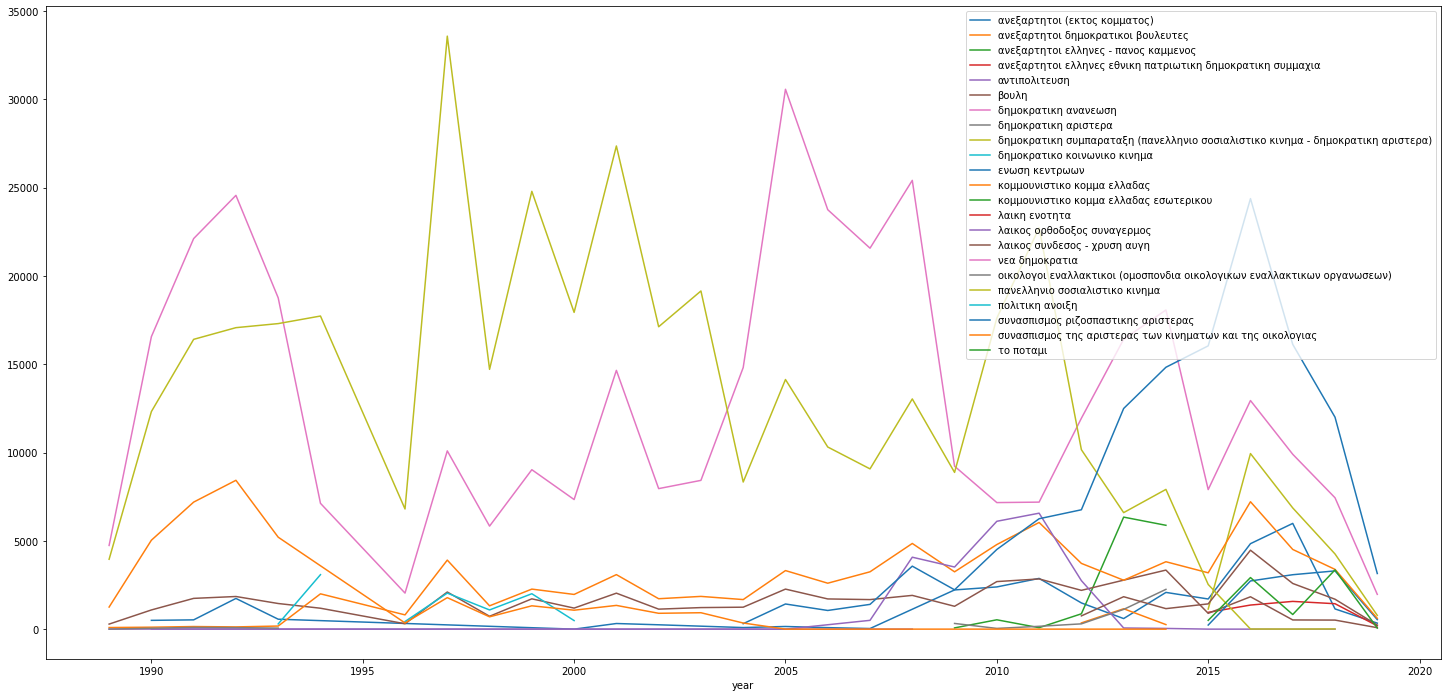

In [8]:
dates = speechs.groupby(['political_party','year']).count()
dates = dates.reset_index()
dates.set_index('year', inplace=True)
plt.figure(figsize =(25, 12))

dates.groupby('political_party')['speech'].plot(legend='True')

plt.show()

* Lets also see the number of speeches per party in a barchart.

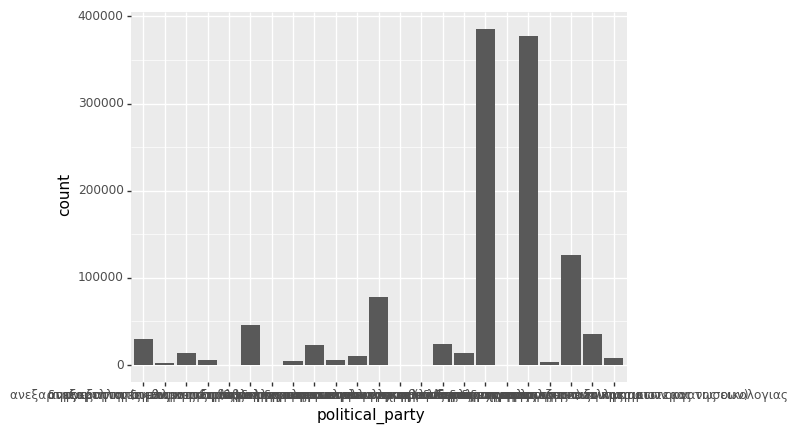

<ggplot: (8789047788933)>

In [9]:
from plotnine.data import mpg
from plotnine import ggplot, aes, geom_bar

ggplot(speech) + aes(x="political_party") + geom_bar()

* **Run the notebook up until here, then navigate to the end of this notebook, run the last two cells and access the link for a dash GUI of every political partys timeline. It is placed at the end to not interrupt the flow of the notebook**

# **Classification with Machine learning algorithms**

* Preprocessing

* Sorting `political_parties` based on number of speeches.

In [10]:
grouped = speech.groupby(['political_party']).count()
grouped = grouped.sort_values('speech')


* Removing 13 classes that seem trivial for our purposes. For this part of the assignment, we are only going to keep the top 10 `political_parties` based on total number of speeches. 

In [11]:
speech = speech[speech.political_party != "αντιπολιτευση"]
speech = speech[speech.political_party != "κομμουνιστικο κομμα ελλαδας εσωτερικου"]
speech = speech[speech.political_party != "οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)"]
speech = speech[speech.political_party != "λαικη ενοτητα"]
speech = speech[speech.political_party != "ανεξαρτητοι (εκτος κομματος)"]
speech = speech[speech.political_party != "ανεξαρτητοι δημοκρατικοι βουλευτες"]
speech = speech[speech.political_party != "πολιτικη ανοιξη"]
speech = speech[speech.political_party != "δημοκρατικη αριστερα"]
speech = speech[speech.political_party != "ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια"]
speech = speech[speech.political_party != "δημοκρατικο κοινωνικο κινημα"]
speech = speech[speech.political_party != "το ποταμι"]
speech = speech[speech.political_party != "ενωση κεντρωων"]

speech.shape

(1124924, 3)

In [12]:
speech = speech.rename(columns={"δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)": "δημοκρατικη συμπαραταξη", "ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια": 'Α.Ε.Ε.Π.Δ.Σ.',"οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)":"οικολογοι εναλλακτικοι","νεα δημοκρατια":"Ν.Δ.","κομμουνιστικο κομμα ελλαδας":"KKE"})


* Shuffling the dataframe.

In [13]:
speech = speech.sample(frac = 1)

* Getting stopwords from ntlk. In addition to these, several other stopwords were added based on my assumptions.

In [14]:
stoppers = ['αλλά','αν','αντι','από', 'αυτά', 'αυτές', 'αυτή', 'αυτό', 'αυτοί', 'αυτός', 'αυτούς', 'αυτών', 'αἱ', 'αἳ', 'αἵ', 'αὐτόσ', 'αὐτὸς', 'αὖ', 'γάρ','γα', 'γα^','γε', 'για', 'γοῦν', 'γὰρ', "δ'", 'δέ', 'δή', 'δαί','δαίσ', 'δαὶ', 'δαὶς', 'δε', 'δεν', "δι'", 'διά', 'διὰ','δὲ', 'δὴ', 'δ’', 'εάν', 'είμαι','είμαστε','είναι','είσαι','είστε','εκείνα','εκείνες', 'εκείνη', 'εκείνο', 'εκείνοι', 'εκείνος', 'εκείνους', 'εκείνων', 'ενώ', 'επ', 'επι', 'εἰ', 'εἰμί', 'εἰμὶ', 'εἰς', 'εἰσ', 'εἴ', 'εἴμι', 'εἴτε', 'η', 'θα', 'ίσως', 'κ', 'και', 'καίτοι','καθ', 'και', 'κατ', 'κατά', 'κατα', 'κατὰ', 'καὶ', 'κι', 'κἀν', 'κἂν', 'μέν', 'μή', 'μήτε', 'μα','με', 'μεθ','μετ', 'μετά','μετα','μετὰ', 'μη','μην', 'μἐν', 'μὲν','μὴ','μὴν', 'να', 'ο', 'οι', 'όμως', 'όπως','όσο','οτι','οἱ','οἳ', 'οἷς','οὐ','οὐδ', 'οὐδέ', 'οὐδείσ', 'οὐδεὶς', 'οὐδὲ', 'οὐδὲν', 'οὐκ','οὐχ', 'οὐχὶ', 'οὓς', 'οὔτε', 'οὕτω', 'οὕτως', 'οὕτωσ', 'οὖν', 'οὗ', 'οὗτος', 'οὗτοσ', 'παρ','παρά','παρα','παρὰ','περί','περὶ','ποια','ποιεσ','ποιό','ποιοί','ποιός','ποιούς','ποιών','ποτέ','που','ποῦ','προ','προσ','πρόσ','πρὸ','πρὸς','πως','πωσ','σε','στη','στην','στο','στον','σόσ','σύ','σύν','σὸς','σὺ','σὺν','τά','τήν','τί','τίς','τίσ','τα','ταῖς','τε','την','τησ','τι','τινα','τις','τισ','το','τοί','τοι','τοιοῦτος','τοιοῦτοσ','τον','τότε','του','τούσ','τοὺς','τοῖς','τοῦ','των','τό','τόν','τότε','τὰ','τὰς','τὴν','τὸ','τὸν','τῆς','τῆσ','τῇ','τῶν','τῷ','ωσ',"ἀλλ'",'ἀλλά','ἀλλὰ','ἀλλ’','ἀπ','ἀπό','ἀπὸ','ἀφ','ἂν','ἃ','ἄλλος','ἄλλοσ','ἄν','ἄρα','ἅμα','ἐάν','ἐγώ','εγώ','ἐκ','ἐμόσ','ἐμὸς','ἐν','ἐξ','ἐπί','ἐπεὶ','ἐπὶ','ἐστι','ἐφ','ἐὰν','ἑαυτοῦ','ἔτι','ἡ','ἢ','ἣ','ἤ','ἥ','ἧς','ἵνα','ὁ','ὃ','ὃν','ὃς','ὅ','ὅδε','ὅθεν','ὅπερ','ὅς','ὅσ','ὅστις','τους','της','οτι','τις','σας','μας','τη','μ','ὅστισ','ότι','ή','τους','στα','στις','στους','ως','-','ὅτε','ὅτι','ὑμόσ','ὑπ','ὑπέρ','ὑπό','ὑπὲρ','ὑπὸ','ὡς','ὡσ','ὥς','ὥστε','ὦ','ᾧ']
STOPWORDS = set(stoppers)


* The function `clean_text()` removes digits, stopwords and turns all text to lower case. We are going to apply it to the dataframe.

In [15]:
import nltk
def clean_text(text):
    
    text = ''.join([i for i in text if not i.isdigit()])
    text = text.lower() 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)

    return text
 
speech['speech'] = speech['speech'].apply(clean_text)
speech

,political_party,speech,year
614176,πανελληνιο σοσιαλιστικο κινημα,"κ. τζέκης ζήτησε λόγο επί διαδικασίας, κύριε π...",2007
351059,κομμουνιστικο κομμα ελλαδας,"ευχαριστώ, κύριε πρόεδρε.θα προσπαθήσω γίνεται...",1999
1114403,λαικος συνδεσος - χρυση αυγη,όχι.,2017
405976,πανελληνιο σοσιαλιστικο κινημα,κύριε λαφαζάνη όταν πας ευρωπαϊκά όργανα συζητ...,2001
630557,πανελληνιο σοσιαλιστικο κινημα,"απλήρωτοι, κύριε υπουργέ.",2007
...,...,...,...
989032,βουλη,"δεκτή, δεκτή.",2015
742618,πανελληνιο σοσιαλιστικο κινημα,ευχαριστούμε κ. μαρκάκη.επιβεβαιώνω -επειδή επ...,2010
683131,νεα δημοκρατια,"κύριε κουτμερίδη, πρόεδρος απαγορεύει.",2008
419915,νεα δημοκρατια,"κύριε πρόεδρε, ακούγοντας κ. μαγκριώτη προσπαθ...",2001


* **Lets take a look at our main dataframe once again.**

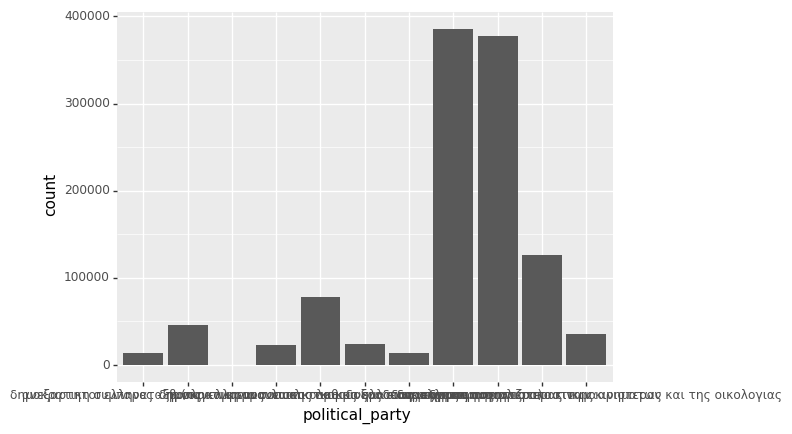

<ggplot: (8787255232253)>

In [16]:
ggplot(speech) + aes(x="political_party") + geom_bar() 

* We notice that the dataset is imbalanced. Lets pick 50.000 random speeches from the top classes in order to fix this problem.

In [17]:
shuffled_df = speech.sample(frac=1,random_state=4)

fraud_df = shuffled_df.loc[shuffled_df['political_party'] != 'νεα δημοκρατια']

non_fraud_df = shuffled_df.loc[shuffled_df['political_party'] == 'νεα δημοκρατια'].sample(n=50000,random_state=42)

normalized_df = pd.concat([fraud_df, non_fraud_df])
speech = normalized_df


shuffled_df = speech.sample(frac=1,random_state=4)

fraud_df = shuffled_df.loc[shuffled_df['political_party'] != 'πανελληνιο σοσιαλιστικο κινημα']

non_fraud_df = shuffled_df.loc[shuffled_df['political_party'] == 'πανελληνιο σοσιαλιστικο κινημα'].sample(n=50000,random_state=42)

normalized_df = pd.concat([fraud_df, non_fraud_df])
speech = normalized_df


shuffled_df = speech.sample(frac=1,random_state=4)

fraud_df = shuffled_df.loc[shuffled_df['political_party'] != 'συνασπισμος ριζοσπαστικης αριστερας']

non_fraud_df = shuffled_df.loc[shuffled_df['political_party'] == 'συνασπισμος ριζοσπαστικης αριστερας'].sample(n=50000,random_state=42)

normalized_df = pd.concat([fraud_df, non_fraud_df])
speech = normalized_df


shuffled_df = speech.sample(frac=1,random_state=4)

fraud_df = shuffled_df.loc[shuffled_df['political_party'] != 'κομμουνιστικο κομμα ελλαδας']

non_fraud_df = shuffled_df.loc[shuffled_df['political_party'] == 'κομμουνιστικο κομμα ελλαδας'].sample(n=50000,random_state=42)

normalized_df = pd.concat([fraud_df, non_fraud_df])
speech = normalized_df


It is not fully balanced but it will suffice for now.

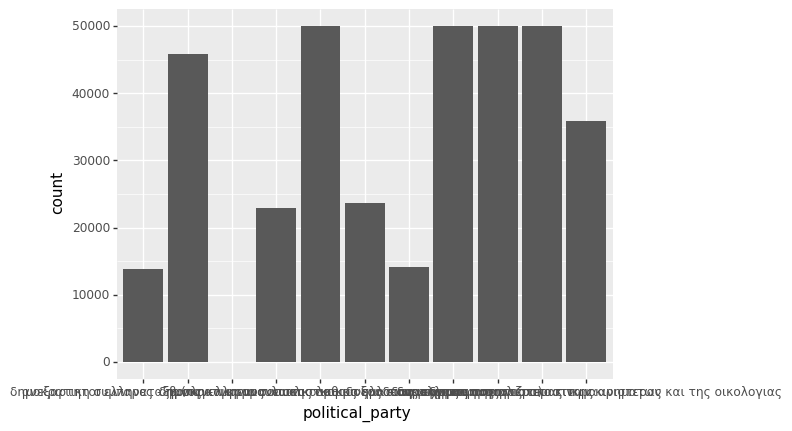

<ggplot: (8787240723837)>

In [18]:
ggplot(speech) + aes(x="political_party") + geom_bar() 

# **Training**

* Splitting the data

In [19]:
X , y = (speech['speech'].values,
        speech['political_party'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

* Lets start with a dummy classifier to measure our models accordingly.

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
y_dummy_pred = dummy_classifier.predict(X_test)
print(metrics.classification_report(y_test, y_dummy_pred, 
                                    zero_division=1))

                                                                                 precision    recall  f1-score   support

                                           ανεξαρτητοι ελληνες - πανος καμμενος       1.00      0.00      0.00      4070
                                                                          βουλη       1.00      0.00      0.00     13809
                                                           δημοκρατικη ανανεωση       1.00      0.00      0.00         1
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       1.00      0.00      0.00      6836
                                                    κομμουνιστικο κομμα ελλαδας       1.00      0.00      0.00     15071
                                                    λαικος ορθοδοξος συναγερμος       1.00      0.00      0.00      7072
                                                   λαικος συνδεσος - χρυση αυγη       1.00      0.00      0.00      4340
                               

In [21]:
metrics.accuracy_score(y_dummy_pred, y_test)

0.13980153942556794

# **1. Naive Bayes** 

In [22]:
from sklearn.pipeline import Pipeline
tf_vectorizer = Pipeline([ ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

* Fitting the model

In [23]:
tf_vectorizer.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

* **Predictions and classification report**

In [24]:
pred_test_std = tf_vectorizer.predict(X_test)

print(f'Prediction accuracy: {metrics.accuracy_score(y_test, pred_test_std):.2%}')

Prediction accuracy: 42.54%


In [25]:
print(metrics.classification_report(y_test, pred_test_std, 
                                    zero_division=1))

                                                                                 precision    recall  f1-score   support

                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.87      0.01      0.03      4070
                                                                          βουλη       0.95      0.98      0.96     13809
                                                           δημοκρατικη ανανεωση       1.00      0.00      0.00         1
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.88      0.01      0.02      6836
                                                    κομμουνιστικο κομμα ελλαδας       0.44      0.55      0.49     15071
                                                    λαικος ορθοδοξος συναγερμος       0.61      0.03      0.05      7072
                                                   λαικος συνδεσος - χρυση αυγη       1.00      0.00      0.00      4340
                               

* **Cross - validation**

In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tf_vectorizer, X, y, cv=5, scoring='accuracy')
scores

array([0.42695211, 0.42695211, 0.42489583, 0.42387172, 0.42648111])

In [27]:
from scipy.stats import sem

print(np.mean(scores), sem(scores))

0.4258305750362329 0.0006184542933644026


# **2. Stochastic Gradient Descent classifier**

With this model i achieved the best results.

In [28]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import HashingVectorizer

sgd = Pipeline([('vect', CountVectorizer(ngram_range = (1,2))),
                     ('tfidf', TfidfTransformer(use_idf = True)),
                     ('clf', SGDClassifier(alpha=0.001,
                                           random_state=42))
                    ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(alpha=0.001, random_state=42))])

* **Cross - validation**

In [29]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd, X, y, cv=5, scoring='accuracy')
scores

array([0.50503633, 0.50670576, 0.50152214, 0.50333188, 0.49957212])

In [30]:
from scipy.stats import sem

print(np.mean(scores), sem(scores))

0.503233647838569 0.001257993488912213


## **Grid search for SGD classifier , results : {'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}**

* The code is commented out in order to not break the flow of the notebook.

In [31]:
#from sklearn.model_selection import GridSearchCV
#parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
             # 'tfidf__use_idf': (True, False),
             # 'clf__alpha': (1e-2, 1e-3)
          #   }

In [32]:
#gs_clf = GridSearchCV(sgd, parameters, n_jobs=-1, cv=5)

In [33]:
#gs_clf = gs_clf.fit(X_train, y_train)

In [34]:
#gs_clf.best_estimator_

* **Predictions and classification report**

In [35]:
ss = sgd.predict(X_test)

print(f'Prediction accuracy: {metrics.accuracy_score(y_test, ss):.2%}')

Prediction accuracy: 50.43%


In [36]:
print(metrics.classification_report(y_test, ss, 
                                    zero_division=1))

                                                                                 precision    recall  f1-score   support

                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.41      0.34      0.37      4070
                                                                          βουλη       0.89      0.98      0.93     13809
                                                           δημοκρατικη ανανεωση       1.00      0.00      0.00         1
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.45      0.38      0.42      6836
                                                    κομμουνιστικο κομμα ελλαδας       0.44      0.58      0.50     15071
                                                    λαικος ορθοδοξος συναγερμος       0.47      0.44      0.45      7072
                                                   λαικος συνδεσος - χρυση αυγη       0.45      0.56      0.50      4340
                               

# **3. Stochastic Gradient Descent with Hashing**

In [37]:
hashingmodel = Pipeline([('vect', HashingVectorizer()),
                     ('tfidf', TfidfTransformer(use_idf = True)),
                     ('clf', SGDClassifier(
                                           alpha=0.001,
                                           random_state=42))
                    ])
hashingmodel.fit(X_train, y_train)

Pipeline(steps=[('vect', HashingVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(alpha=0.001, random_state=42))])

* **Predictions and classification report**

In [38]:
hashh = hashingmodel.predict(X_test)

print(f'Prediction accuracy: {metrics.accuracy_score(y_test, hashh):.2%}')

Prediction accuracy: 47.76%


In [39]:
print(metrics.classification_report(y_test, hashh, 
                                    zero_division=1))

                                                                                 precision    recall  f1-score   support

                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.42      0.33      0.37      4070
                                                                          βουλη       0.85      0.98      0.91     13809
                                                           δημοκρατικη ανανεωση       1.00      0.00      0.00         1
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.41      0.35      0.38      6836
                                                    κομμουνιστικο κομμα ελλαδας       0.42      0.56      0.48     15071
                                                    λαικος ορθοδοξος συναγερμος       0.41      0.42      0.41      7072
                                                   λαικος συνδεσος - χρυση αυγη       0.45      0.55      0.49      4340
                               

* **Cross - validation**

In [40]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(hashingmodel, X, y, cv=5, scoring='accuracy')
scores

array([0.47703488, 0.48141186, 0.47340806, 0.46938174, 0.47720992])

In [41]:
from scipy.stats import sem

print(np.mean(scores), sem(scores))

0.4756892904231627 0.0020231143844052814


# **4. Ada Boost classifier with a decision tree classifier as a base estimator.**

In [42]:
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)

dec = Pipeline([
        ('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', AdaBoostClassifier(base_estimator = DTC))
    ])
dec.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                          max_features='auto',
                                                                          random_state=11)))])

* **Predictions and classification report**

In [43]:
deci = dec.predict(X_test)

print(f'Prediction accuracy: {metrics.accuracy_score(y_test, deci):.2%}')

Prediction accuracy: 36.02%


In [44]:
print(metrics.classification_report(y_test, deci, 
                                    zero_division=1))

                                                                                 precision    recall  f1-score   support

                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.21      0.20      0.21      4070
                                                                          βουλη       0.95      0.98      0.96     13809
                                                           δημοκρατικη ανανεωση       0.00      0.00      0.00         1
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.27      0.25      0.26      6836
                                                    κομμουνιστικο κομμα ελλαδας       0.35      0.37      0.36     15071
                                                    λαικος ορθοδοξος συναγερμος       0.20      0.15      0.17      7072
                                                   λαικος συνδεσος - χρυση αυγη       0.26      0.38      0.31      4340
                               

# **5. Linear regression**

* We are going to try a different approach. Shuffling 5000 rows for each class. 

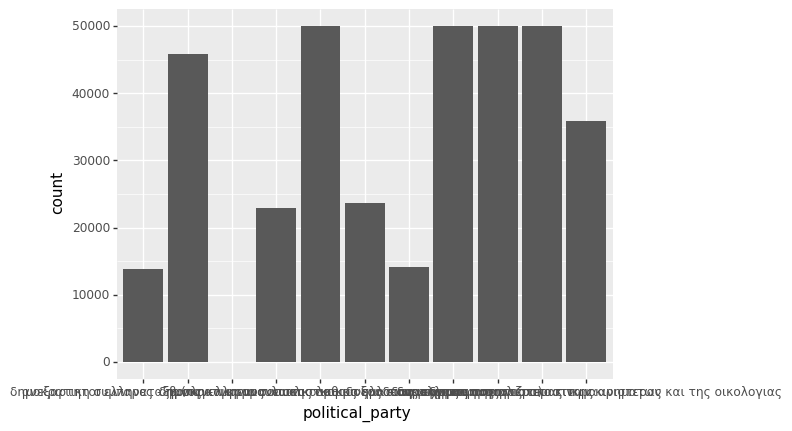

<ggplot: (8787072470457)>

In [49]:
ggplot(speech) + aes(x="political_party") + geom_bar() 

In [57]:
shuffled_df = speech.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset.

#Randomly select 492 observations from the non-fraud (majority class)
df5 = shuffled_df.loc[shuffled_df['political_party'] == 'ανεξαρτητοι ελληνες - πανος καμμενος'].sample(n=5000,random_state=42)
df6 = shuffled_df.loc[shuffled_df['political_party'] == 'λαικος συνδεσος - χρυση αυγη'].sample(n=5000,random_state=42)
df7 = shuffled_df.loc[shuffled_df['political_party'] == 'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)'].sample(n=5000,random_state=42)
df8 = shuffled_df.loc[shuffled_df['political_party'] == 'λαικος ορθοδοξος συναγερμος'].sample(n=5000,random_state=42)
df9 = shuffled_df.loc[shuffled_df['political_party'] == 'συνασπισμος της αριστερας των κινηματων και της οικολογιας'].sample(n=5000,random_state=42)
df10 = shuffled_df.loc[shuffled_df['political_party'] == 'βουλη'].sample(n=5000,random_state=42)
df11 = shuffled_df.loc[shuffled_df['political_party'] == 'κομμουνιστικο κομμα ελλαδας'].sample(n=5000,random_state=42)
df12 = shuffled_df.loc[shuffled_df['political_party'] == 'νεα δημοκρατια'].sample(n=5000,random_state=42)
df13 = shuffled_df.loc[shuffled_df['political_party'] == 'πανελληνιο σοσιαλιστικο κινημα'].sample(n=5000,random_state=42)
df14 = shuffled_df.loc[shuffled_df['political_party'] == 'συνασπισμος ριζοσπαστικης αριστερας'].sample(n=5000,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([df5,df6,df7,df8,df9,df10,df11,df12,df13,df14])


normalized_df

,political_party,speech,year
960835,ανεξαρτητοι ελληνες - πανος καμμενος,"έχουμε δύο προτασσόμενους ομιλητές, οποίοι καν...",2014
870194,ανεξαρτητοι ελληνες - πανος καμμενος,"φαντάζεστε, κύριε υπουργέ, μέσα νοέμβριο έχουμ...",2012
873653,ανεξαρτητοι ελληνες - πανος καμμενος,πλειοψηφία.,2012
889065,ανεξαρτητοι ελληνες - πανος καμμενος,"ευχαριστούμε, κύριε αντιπρόεδρε.το λόγο έχει υ...",2013
976595,ανεξαρτητοι ελληνες - πανος καμμενος,παρών.,2014
...,...,...,...
783912,συνασπισμος ριζοσπαστικης αριστερας,αναρωτηθώ γιατί; έχει έχει;,2011
818969,συνασπισμος ριζοσπαστικης αριστερας,ευχαριστούμε κ. βασιλική αλεξανδρίδου συνέπεια...,2011
1045568,συνασπισμος ριζοσπαστικης αριστερας,"κύριε πρόεδρε, έχουμε κάποια προστασία; συνεχι...",2016
998488,συνασπισμος ριζοσπαστικης αριστερας,ευχαριστούμε. λόγο έχει κ. κεγκέρογλου τρία λε...,2015


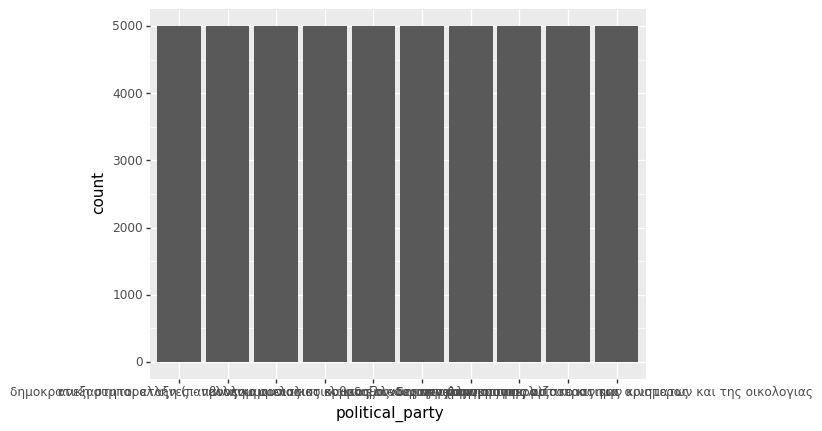

<ggplot: (8787046430193)>

In [60]:
speech = normalized_df
ggplot(speech) + aes(x="political_party") + geom_bar() 

In [61]:
speech.groupby(['political_party']).count().sort_values('speech')

,speech,year
political_party,,
ανεξαρτητοι ελληνες - πανος καμμενος,5000,5000
βουλη,5000,5000
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα),5000,5000
κομμουνιστικο κομμα ελλαδας,5000,5000
λαικος ορθοδοξος συναγερμος,5000,5000
λαικος συνδεσος - χρυση αυγη,5000,5000
νεα δημοκρατια,5000,5000
πανελληνιο σοσιαλιστικο κινημα,5000,5000
συνασπισμος ριζοσπαστικης αριστερας,5000,5000


In [62]:
speech = speech[speech.political_party != "πολιτικη ανοιξη"]
speech = speech[speech.political_party != "δημοκρατικη αριστερα"]

In [63]:
X , y = (speech['speech'].values,
        speech['political_party'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import HashingVectorizer

linear = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(C = 4.281332398719396,penalty = 'l2', solver = 'liblinear'))
                    ])
linear.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=4.281332398719396, solver='liblinear'))])

* **Predictions and classification report**

In [65]:
lin = linear.predict(X_test)


print(f'Prediction accuracy: {metrics.accuracy_score(y_test, lin):.2%}')

Prediction accuracy: 46.39%


In [66]:
print(metrics.classification_report(y_test, lin, 
                                    zero_division=1))

                                                                                 precision    recall  f1-score   support

                                           ανεξαρτητοι ελληνες - πανος καμμενος       0.50      0.48      0.49      1535
                                                                          βουλη       0.92      0.98      0.95      1492
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.46      0.43      0.44      1483
                                                    κομμουνιστικο κομμα ελλαδας       0.38      0.44      0.40      1545
                                                    λαικος ορθοδοξος συναγερμος       0.45      0.41      0.43      1498
                                                   λαικος συνδεσος - χρυση αυγη       0.56      0.57      0.56      1529
                                                                 νεα δημοκρατια       0.25      0.22      0.24      1466
                               

* **Cross - validation**

In [67]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(linear, X, y, cv=5, scoring='accuracy')
scores

array([0.464 , 0.4608, 0.4634, 0.4617, 0.4643])

In [68]:
from scipy.stats import sem

print(np.mean(scores), sem(scores))

0.46284000000000003 0.00068014704292528


* **GridSearch**

In [ ]:
#from sklearn.model_selection import GridSearchCV
#param_range = [9, 10]
#param_range_fl = [1.0, 0.5]
#param_grid = [
    #{
     #'clf__penalty': ['l1', 'l2'],
    #'clf__C' : np.logspace(-4, 4, 20),
    #'clf__solver' : ['liblinear']},
    
#]

## **Grid search results : {'clf__C': 4.281332398719396, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}**


In [ ]:
#clf = GridSearchCV(linear, param_grid = param_grid, n_jobs=-1)
#clf.fit(X_train, y_train)
#clf.best_params_

# **Classification with a Neural Network**

* The code below is used to enable the tpu of google colab.

In [29]:
#%tensorflow_version 2.x
import tensorflow as tf
#print("Tensorflow version " + tf.__version__)

#try:
 # tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
 # print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#except ValueError:
 # raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.108.235.130:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.108.235.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.108.235.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## **Reading the dataset once again, we are going to preprocess it differently.**

In [2]:
import pandas as pd
speechs=pd.read_csv('https://zenodo.org/record/2587904/files/Greek_Parliament_Proceedings_1989_2019.csv.zip', dtype = str)
speechs.isnull().sum()
speechs = speechs.sample(frac = 1)
speechs

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ..."
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...
...,...,...,...,...,...,...,...,...
1194402,συντυχακης δανιηλ εμμανουηλ,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ..."
1194403,κακλαμανης μιχαηλ νικητας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,προεδρευων,"Ορίστε, κύριε Υπουργέ, έχετε τον λόγο."
1194404,κακλαμανης μιχαηλ νικητας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,προεδρευων,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ..."
1194405,NaN,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."


## **Importing necessary modules.**

In [3]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from datetime import datetime
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [5]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

* **Removing null values, isolating columns that we need.**

In [6]:
sp = pd.DataFrame()
sp['political_party'] = speechs['political_party']
sp['speech'] = speechs['speech']

speech = sp
speech = speech.dropna()
speech.isnull().sum()

political_party    0
speech             0
dtype: int64

In [7]:
speech = speech.astype(str)
speech['political_party'] = pd.factorize(speech['political_party'])[0] + 1


* Setting the same stopwords as before.

In [8]:
 stoppers = ['αλλά','αν','αντι','από', 'αυτά', 'αυτές', 'αυτή', 'αυτό', 'αυτοί', 'αυτός', 'αυτούς', 'αυτών', 'αἱ', 'αἳ', 'αἵ', 'αὐτόσ', 'αὐτὸς', 'αὖ', 'γάρ','γα', 'γα^','γε', 'για', 'γοῦν', 'γὰρ', "δ'", 'δέ', 'δή', 'δαί','δαίσ', 'δαὶ', 'δαὶς', 'δε', 'δεν', "δι'", 'διά', 'διὰ','δὲ', 'δὴ', 'δ’', 'εάν', 'είμαι','είμαστε','είναι','είσαι','είστε','εκείνα','εκείνες', 'εκείνη', 'εκείνο', 'εκείνοι', 'εκείνος', 'εκείνους', 'εκείνων', 'ενώ', 'επ', 'επι', 'εἰ', 'εἰμί', 'εἰμὶ', 'εἰς', 'εἰσ', 'εἴ', 'εἴμι', 'εἴτε', 'η', 'θα', 'ίσως', 'κ', 'και', 'καίτοι','καθ', 'και', 'κατ', 'κατά', 'κατα', 'κατὰ', 'καὶ', 'κι', 'κἀν', 'κἂν', 'μέν', 'μή', 'μήτε', 'μα','με', 'μεθ','μετ', 'μετά','μετα','μετὰ', 'μη','μην', 'μἐν', 'μὲν','μὴ','μὴν', 'να', 'ο', 'οι', 'όμως', 'όπως','όσο','οτι','οἱ','οἳ', 'οἷς','οὐ','οὐδ', 'οὐδέ', 'οὐδείσ', 'οὐδεὶς', 'οὐδὲ', 'οὐδὲν', 'οὐκ','οὐχ', 'οὐχὶ', 'οὓς', 'οὔτε', 'οὕτω', 'οὕτως', 'οὕτωσ', 'οὖν', 'οὗ', 'οὗτος', 'οὗτοσ', 'παρ','παρά','παρα','παρὰ','περί','περὶ','ποια','ποιεσ','ποιό','ποιοί','ποιός','ποιούς','ποιών','ποτέ','που','ποῦ','προ','προσ','πρόσ','πρὸ','πρὸς','πως','πωσ','σε','στη','στην','στο','στον','σόσ','σύ','σύν','σὸς','σὺ','σὺν','τά','τήν','τί','τίς','τίσ','τα','ταῖς','τε','την','τησ','τι','τινα','τις','τισ','το','τοί','τοι','τοιοῦτος','τοιοῦτοσ','τον','τότε','του','τούσ','τοὺς','τοῖς','τοῦ','των','τό','τόν','τότε','τὰ','τὰς','τὴν','τὸ','τὸν','τῆς','τῆσ','τῇ','τῶν','τῷ','ωσ',"ἀλλ'",'ἀλλά','ἀλλὰ','ἀλλ’','ἀπ','ἀπό','ἀπὸ','ἀφ','ἂν','ἃ','ἄλλος','ἄλλοσ','ἄν','ἄρα','ἅμα','ἐάν','ἐγώ','εγώ','ἐκ','ἐμόσ','ἐμὸς','ἐν','ἐξ','ἐπί','ἐπεὶ','ἐπὶ','ἐστι','ἐφ','ἐὰν','ἑαυτοῦ','ἔτι','ἡ','ἢ','ἣ','ἤ','ἥ','ἧς','ἵνα','ὁ','ὃ','ὃν','ὃς','ὅ','ὅδε','ὅθεν','ὅπερ','ὅς','ὅσ','ὅστις','τους','της','οτι','τις','σας','μας','τη','μ','ὅστισ','ότι','ή','τους','στα','στις','στους','ως','-','ὅτε','ὅτι','ὑμόσ','ὑπ','ὑπέρ','ὑπό','ὑπὲρ','ὑπὸ','ὡς','ὡσ','ὥς','ὥστε','ὦ','ᾧ']

In [9]:
STOPWORDS = set(stoppers)

In [10]:
sp = pd.DataFrame()
sp['political_party'] = speechs['political_party']
sp['speech'] = speechs['speech']

speech = sp

In [11]:
sp = pd.DataFrame()
sp['political_party'] = speechs['political_party']
sp['speech'] = speechs['speech']

speech = sp

* **We are going to keep the 8 major political parties based on our analysis.**

In [12]:
speech = speech[speech.political_party != "αντιπολιτευση"]
speech = speech[speech.political_party != "κομμουνιστικο κομμα ελλαδας εσωτερικου"]
speech = speech[speech.political_party != "οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων)"]
speech = speech[speech.political_party != "λαικη ενοτητα"]
speech = speech[speech.political_party != "ανεξαρτητοι (εκτος κομματος)"]
speech = speech[speech.political_party != "ανεξαρτητοι δημοκρατικοι βουλευτες"]
speech = speech[speech.political_party != "δημοκρατικη ανανεωση"]

speech = speech[speech.political_party != "πολιτικη ανοιξη"]
speech = speech[speech.political_party != "δημοκρατικη αριστερα"]
speech = speech[speech.political_party != "ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια"]
speech = speech[speech.political_party != "δημοκρατικο κοινωνικο κινημα	"]
speech = speech[speech.political_party != "το ποταμι"]
speech = speech[speech.political_party != "ενωση κεντρωων"]
speech = speech[speech.political_party != "δημοκρατικο κοινωνικο κινημα"]
speech = speech[speech.political_party != "λαικος συνδεσος - χρυση αυγη"]
speech = speech[speech.political_party != "ανεξαρτητοι ελληνες - πανος καμμενος"]





speech.shape

(1097133, 2)

In [13]:
speech["speech"] = speech["speech"].astype('str')
speech.dtypes

political_party    object
speech             object
dtype: object

In [14]:
speech = speech.dropna()
speech.political_party.unique()

array(['πανελληνιο σοσιαλιστικο κινημα', 'βουλη', 'νεα δημοκρατια',
       'κομμουνιστικο κομμα ελλαδας',
       'συνασπισμος της αριστερας των κινηματων και της οικολογιας',
       'λαικος ορθοδοξος συναγερμος',
       'συνασπισμος ριζοσπαστικης αριστερας',
       'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)'],
      dtype=object)

* **Removing punctuation.**

In [15]:
import string

def remove_punct(text):
    table = str.maketrans(" "," ",string.punctuation)
    return text.translate(table)
speech["speech"] = speech.speech.map(lambda x: remove_punct(x))

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


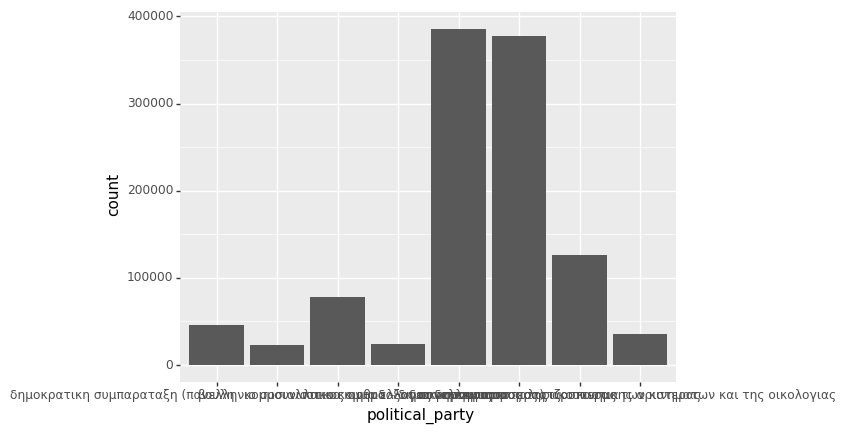

<ggplot: (8768365505842)>

In [19]:
from plotnine.data import mpg
from plotnine import ggplot, aes, geom_bar
ggplot(speech) + aes(x="political_party") + geom_bar()

In [20]:
grouped = speech.groupby(['political_party']).count()
grouped.sort_values(by = 'speech')

,speech
political_party,
δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα),22991
λαικος ορθοδοξος συναγερμος,23686
συνασπισμος της αριστερας των κινηματων και της οικολογιας,35891
βουλη,45876
κομμουνιστικο κομμα ελλαδας,78631
συνασπισμος ριζοσπαστικης αριστερας,126572
πανελληνιο σοσιαλιστικο κινημα,377684
νεα δημοκρατια,385640


* **Removing digits, replacing characters with lower case characters, removing stopwords.**

In [21]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
import nltk
def clean_text(text):
   
    text = ''.join([i for i in text if not i.isdigit()])

    text = text.lower() 

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    return text
    
speech['speech'] = speech['speech'].apply(clean_text)

In [22]:
speech = speech.reset_index(drop = True)


* **Splitting data**

In [23]:
X , y = (speech['speech'].values,
        speech['political_party'].values)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=42)
X_train.shape

(767879,)

* **Counting unique words in dataset**

In [24]:
from collections import Counter

def count_word(text):
    count = Counter()
    for i in text:
        for word in i.split():
         count[word] += 1 
    return count

In [25]:
text = X_train
counter = count_word(text)

In [26]:
num_words = len(counter)



max_length = 40

* **Fitting the training speeches to the keras preprocessing tokenizer.**

In [27]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(X_train)

In [28]:
word_index = tokenizer.word_index

* Getting sequences of numbers from training and testing speeches 

In [29]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

* Adding a padding so that every sequence has the same length

In [30]:
from keras.preprocessing.sequence import pad_sequences

Xtr = pad_sequences(
  train_sequences, maxlen = max_length, padding = "post", truncating = "post"
)
Xte= pad_sequences(
  test_sequences, maxlen = max_length, padding = "post", truncating = "post"
)

* This is our corpus.

In [31]:
word_index

{'έχει': 1,
 'κύριε': 2,
 'ένα': 3,
 'πρέπει': 4,
 'γιατί': 5,
 'μια': 6,
 'οποία': 7,
 'μία': 8,
 'έχουν': 9,
 'πολύ': 10,
 'υπάρχει': 11,
 'έχουμε': 12,
 'λόγο': 13,
 'συνάδελφοι': 14,
 'κυβέρνηση': 15,
 'πρόεδρε': 16,
 'σήμερα': 17,
 'εδώ': 18,
 'ήταν': 19,
 'κύριοι': 20,
 'μου': 21,
 'μπορεί': 22,
 'μόνο': 23,
 'όχι': 24,
 'λοιπόν': 25,
 'θέμα': 26,
 'οποίο': 27,
 'υπουργέ': 28,
 'όταν': 29,
 'αυτήν': 30,
 'προς': 31,
 'άρθρο': 32,
 'τώρα': 33,
 'δηλαδή': 34,
 'εμείς': 35,
 'μέσα': 36,
 'δύο': 37,
 'όλα': 38,
 'έχετε': 39,
 'πολιτική': 40,
 'νομοσχέδιο': 41,
 'πω': 42,
 'αφορά': 43,
 'χρόνια': 44,
 'γίνεται': 45,
 'υπάρχουν': 46,
 'διότι': 47,
 'εσείς': 48,
 'γίνει': 49,
 'επί': 50,
 'κάθε': 51,
 'υπουργός': 52,
 'χώρα': 53,
 'κάνει': 54,
 'ούτε': 55,
 'πασοκ': 56,
 'μέχρι': 57,
 'έτσι': 58,
 'δεκτό': 59,
 'ευχαριστώ': 60,
 'συζήτηση': 61,
 'είχε': 62,
 'δημοκρατίας': 63,
 'έγινε': 64,
 'χωρίς': 65,
 'νέα': 66,
 'όλοι': 67,
 'θέλω': 68,
 'κυρίες': 69,
 'πρόβλημα': 70,
 'μάλιστα': 7

* Testing to see if it works correctly.

In [32]:
print(X_train[20])
print(train_sequences[20])


εμείς ευχαριστούμε
[35, 313]


Testing that our sequences can be decoded to text to evaluate our work.

In [33]:
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

In [34]:
def decode(text):
    return " ".join([reverse_word_index.get(i,"?")for i in text])

In [35]:
decode(Xtr[20])

'εμείς ευχαριστούμε ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?'

For our training and testing answers we are going to use .get_dummies function which pivots the matrix of y_train, y_test creating a new matrix with columns = political_parties and rows = speeches where 1 is the value of a cell that connects political party with its speeches and 0 otherwise.

In [36]:
Ytr = pd.get_dummies(y_train).values
Yte = pd.get_dummies(y_test).values

In [37]:
print(Xtr.shape)
print(Ytr.shape)

(767879, 40)
(767879, 8)


We are going to apply a random oversampler to balance our data without limiting it like before.

In [38]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train, Y_train = ros.fit_resample(Xtr, Ytr)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Notice the data almost tripling in size.

In [39]:
print(X_train.shape)
print(Y_train.shape)

(2161456, 40)
(2161456, 8)


# **Creating the model**. 
* Starting with an embedding layer
* One LSTM layer 
* One Dense layer

We are going to use a `softmax` activation function and an `adam` optimizer.

* I experimented with various architectures, activation functions, numbers of layers and hyperparameters.

 * The embedding output is set to 32 to manage time of training.
 * The LSTM layer is set to 64 with a dropout rate of 0.5. I had slightly better results (43% val_accuracy) with a dropout of 0.1 but there was no time to train it again so below i display the results with a dropout rate of 0.5.
 
 * The dense layer has 8 neurons due to the number of our classes and the activation function is softmax since its known to be effective for multiclass classification problems.
 
 * No extra hidden layers were added in order to limit parameter number and overfitting.

In [43]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def create_model():
  model = Sequential()

  model.add(Embedding (num_words, 32,input_length =max_length))
  model.add(LSTM(64, dropout= 0.05))



  model.add(Dense(8, activation = "softmax"))
  

  optimizer = Adam(learning_rate = 3e-4)

  model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

  return model
#with tpu_strategy.scope():
  model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 32)            24623232  
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 24,648,584
Trainable params: 24,648,584
Non-trainable params: 0
_________________________________________________________________


* Training the model. Again, trial and error process took place to find the best batch size and number of epochs whilst managing time of training.

In [44]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)




history = model.fit(
 X_train, Y_train, epochs = 15,batch_size = 256, validation_data = (Xte, Yte),callbacks = [callback] 
)

Epoch 1/15
8444/8444 [==============================] - 252s 29ms/step - loss: 1.5926 - accuracy: 0.3491 - val_loss: 1.7051 - val_accuracy: 0.2657
Epoch 2/15
8444/8444 [==============================] - 240s 28ms/step - loss: 1.0573 - accuracy: 0.5973 - val_loss: 1.5547 - val_accuracy: 0.3507
Epoch 3/15
8444/8444 [==============================] - 242s 29ms/step - loss: 0.9130 - accuracy: 0.6473 - val_loss: 1.5804 - val_accuracy: 0.3594
Epoch 4/15
8444/8444 [==============================] - 242s 29ms/step - loss: 0.8472 - accuracy: 0.6738 - val_loss: 1.5941 - val_accuracy: 0.3716
Epoch 5/15
8444/8444 [==============================] - 242s 29ms/step - loss: 0.7994 - accuracy: 0.6948 - val_loss: 1.6814 - val_accuracy: 0.3763
Epoch 6/15
8444/8444 [==============================] - 240s 28ms/step - loss: 0.7630 - accuracy: 0.7106 - val_loss: 1.7035 - val_accuracy: 0.3923
Epoch 7/15
8444/8444 [==============================] - 239s 28ms/step - loss: 0.7346 - accuracy: 0.7227 - val_loss: 1

**`val_accuracy` : 0.40%, `accuracy` = 0.76%**

In [45]:
#accr = model.evaluate(X_test,Y_test)
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

* Training loss and testing loss

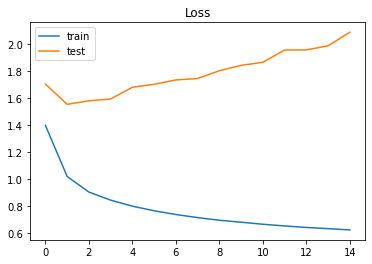

In [46]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

* Training accuracy and testing accuracy

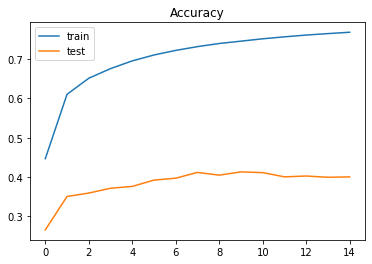

In [47]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# **Text Generation**

* Importing necessary modules.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os
import time

* Importing the dataset once again.

In [2]:
import pandas as pd
speechs=pd.read_csv('https://zenodo.org/record/2587904/files/Greek_Parliament_Proceedings_1989_2019.csv.zip', dtype = str)
speechs.isnull().sum()
speechs

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ..."
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...
...,...,...,...,...,...,...,...,...
1194402,συντυχακης δανιηλ εμμανουηλ,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,κομμουνιστικο κομμα ελλαδας,NaN,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ..."
1194403,κακλαμανης μιχαηλ νικητας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,προεδρευων,"Ορίστε, κύριε Υπουργέ, έχετε τον λόγο."
1194404,κακλαμανης μιχαηλ νικητας,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,νεα δημοκρατια,προεδρευων,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ..."
1194405,NaN,2019-02-22,period 17 presided parliamentary republic,session 4,sitting 82,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."


* This time we are not going to remove punctuation or higher case characters. This function removes the digits from the text.
Applying it to our dataset.

In [35]:
speechs = speechs.astype(str)



* Picking one random `political_party` to generate text from, limiting dataset to 5.000 rows for training time management.

In [36]:
generate = speechs.loc[speechs['political_party'] == 'κομμουνιστικο κομμα ελλαδας'].head(5000)


In [37]:
import nltk
def clean_text(text):

    text = ''.join([i for i in text if not i.isdigit()])

    return text
    
generate['speech'] = generate['speech'].apply(clean_text)

In [38]:
generate

,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
97,καππος βασιλειου κωνσταντινος,1989-07-07,period 5,session 1,sitting 5,κομμουνιστικο κομμα ελλαδας,nan,Δεν χρειάζεται. ΓΙΑΝΝΗΣ Ν.
98,καππος βασιλειου κωνσταντινος,1989-07-07,period 5,session 1,sitting 5,κομμουνιστικο κομμα ελλαδας,nan,Είπα και εναντίον του ΠΑΣΟΚ. ΓΙΑΝΝΗΣ Ν.
1896,κορακας χρηστου ευστρατιος,1989-07-21,period 5,session 1,sitting 11,κομμουνιστικο κομμα ελλαδας,nan,"Είπαμε, ότι θέλουμε να συζητηθεί το θέμα."
1949,κορακας χρηστου ευστρατιος,1989-07-21,period 5,session 1,sitting 11,κομμουνιστικο κομμα ελλαδας,nan,Υπάρχει Σύνταγμα και κακώς διώξατε τους αστυν...
2317,κορακας χρηστου ευστρατιος,1989-09-01,period 5,session 1,sitting 28,κομμουνιστικο κομμα ελλαδας,nan,Κάπως καθυστερημένα!
...,...,...,...,...,...,...,...,...
256001,γκατζης φιλιππου νικολαος,1997-05-21,period 9 presided parliamentary republic,session 1,sitting 132,κομμουνιστικο κομμα ελλαδας,nan,Κατά πλειοψηφία.
256005,γκατζης φιλιππου νικολαος,1997-05-21,period 9 presided parliamentary republic,session 1,sitting 132,κομμουνιστικο κομμα ελλαδας,nan,Κατά πλειοψηφία.
256009,γκατζης φιλιππου νικολαος,1997-05-21,period 9 presided parliamentary republic,session 1,sitting 132,κομμουνιστικο κομμα ελλαδας,nan,Κατά πλειοψηφία.
256013,γκατζης φιλιππου νικολαος,1997-05-21,period 9 presided parliamentary republic,session 1,sitting 132,κομμουνιστικο κομμα ελλαδας,nan,Κατά πλειοψηφία.


 * Creating one big string by adding all 10000 speeches with a space inbetween.

In [39]:
text = generate.speech.str.cat(sep=' ')

* Counting the unique characters.

In [40]:
text[15]

'.'

In [41]:
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

145 unique characters


* **Vectorizing text**

In [42]:
example_texts = ['Καλησπέρα', 'Σήμερα']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'\xce\x9a', b'\xce\xb1', b'\xce\xbb', b'\xce\xb7', b'\xcf\x83', b'\xcf\x80', b'\xce\xad', b'\xcf\x81', b'\xce\xb1'], [b'\xce\xa3', b'\xce\xae', b'\xce\xbc', b'\xce\xb5', b'\xcf\x81', b'\xce\xb1']]>

In [43]:
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))

In [44]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[93, 113, 123, 119, 131, 128, 110, 129, 113], [101, 111, 124, 117, 129, 113]]>

In [45]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'\xce\x9a', b'\xce\xb1', b'\xce\xbb', b'\xce\xb7', b'\xcf\x83', b'\xcf\x80', b'\xce\xad', b'\xcf\x81', b'\xce\xb1'], [b'\xce\xa3', b'\xce\xae', b'\xce\xbc', b'\xce\xb5', b'\xcf\x81', b'\xce\xb1']]>

In [46]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'\xce\x9a\xce\xb1\xce\xbb\xce\xb7\xcf\x83\xcf\x80\xce\xad\xcf\x81\xce\xb1',
       b'\xce\xa3\xce\xae\xce\xbc\xce\xb5\xcf\x81\xce\xb1'], dtype=object)

In [47]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

* Dividing the text into example sequences.

In [48]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(5931792,), dtype=int64, numpy=array([  2,  87, 117, ..., 112, 113,  12])>

In [49]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [50]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

 
Δ
ε
ν
 
χ
ρ
ε
ι
ά


In [51]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

In [52]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
    print(chars_from_ids(seq))

tf.Tensor(
[b' ' b'\xce\x94' b'\xce\xb5' b'\xce\xbd' b' ' b'\xcf\x87' b'\xcf\x81'
 b'\xce\xb5' b'\xce\xb9' b'\xce\xac' b'\xce\xb6' b'\xce\xb5' b'\xcf\x84'
 b'\xce\xb1' b'\xce\xb9' b'.' b' ' b'\xce\x93' b'\xce\x99' b'\xce\x91'
 b'\xce\x9d' b'\xce\x9d' b'\xce\x97' b'\xce\xa3' b' ' b'\xce\x9d' b'.'
 b' ' b' ' b'\xce\x95' b'\xce\xaf' b'\xcf\x80' b'\xce\xb1' b' '
 b'\xce\xba' b'\xce\xb1' b'\xce\xb9' b' ' b'\xce\xb5' b'\xce\xbd'
 b'\xce\xb1' b'\xce\xbd' b'\xcf\x84' b'\xce\xaf' b'\xce\xbf' b'\xce\xbd'
 b' ' b'\xcf\x84' b'\xce\xbf' b'\xcf\x85' b' ' b'\xce\xa0' b'\xce\x91'
 b'\xce\xa3' b'\xce\x9f' b'\xce\x9a' b'.' b' ' b'\xce\x93' b'\xce\x99'
 b'\xce\x91' b'\xce\x9d' b'\xce\x9d' b'\xce\x97' b'\xce\xa3' b' '
 b'\xce\x9d' b'.' b' ' b' ' b'\xce\x95' b'\xce\xaf' b'\xcf\x80'
 b'\xce\xb1' b'\xce\xbc' b'\xce\xb5' b',' b' ' b'\xcf\x8c' b'\xcf\x84'
 b'\xce\xb9' b' ' b'\xce\xb8' b'\xce\xad' b'\xce\xbb' b'\xce\xbf'
 b'\xcf\x85' b'\xce\xbc' b'\xce\xb5' b' ' b'\xce\xbd' b'\xce\xb1' b' '
 b'\xcf\x83' b'\xcf\

In [53]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b' \xce\x94\xce\xb5\xce\xbd \xcf\x87\xcf\x81\xce\xb5\xce\xb9\xce\xac\xce\xb6\xce\xb5\xcf\x84\xce\xb1\xce\xb9. \xce\x93\xce\x99\xce\x91\xce\x9d\xce\x9d\xce\x97\xce\xa3 \xce\x9d.  \xce\x95\xce\xaf\xcf\x80\xce\xb1 \xce\xba\xce\xb1\xce\xb9 \xce\xb5\xce\xbd\xce\xb1\xce\xbd\xcf\x84\xce\xaf\xce\xbf\xce\xbd \xcf\x84\xce\xbf\xcf\x85 \xce\xa0\xce\x91\xce\xa3\xce\x9f\xce\x9a. \xce\x93\xce\x99\xce\x91\xce\x9d\xce\x9d\xce\x97\xce\xa3 \xce\x9d.  \xce\x95\xce\xaf\xcf\x80\xce\xb1\xce\xbc\xce\xb5, \xcf\x8c\xcf\x84\xce\xb9 \xce\xb8\xce\xad\xce\xbb\xce\xbf\xcf\x85\xce\xbc\xce\xb5 \xce\xbd\xce\xb1 \xcf\x83\xcf\x85\xce\xb6\xce\xb7\xcf\x84\xce\xb7\xce\xb8\xce\xb5'
b'\xce\xaf \xcf\x84\xce\xbf \xce\xb8\xce\xad\xce\xbc\xce\xb1.  \xce\xa5\xcf\x80\xce\xac\xcf\x81\xcf\x87\xce\xb5\xce\xb9 \xce\xa3\xcf\x8d\xce\xbd\xcf\x84\xce\xb1\xce\xb3\xce\xbc\xce\xb1 \xce\xba\xce\xb1\xce\xb9 \xce\xba\xce\xb1\xce\xba\xcf\x8e\xcf\x82 \xce\xb4\xce\xb9\xcf\x8e\xce\xbe\xce\xb1\xcf\x84\xce\xb5 \xcf\x84\xce\xbf\xcf\x85\xcf\x82 \xce\xb1

In [54]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [55]:
split_input_target(list("Tensorflow"))


(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [56]:
dataset = sequences.map(split_input_target)

In [57]:
for input_example, target_example in  dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b' \xce\x94\xce\xb5\xce\xbd \xcf\x87\xcf\x81\xce\xb5\xce\xb9\xce\xac\xce\xb6\xce\xb5\xcf\x84\xce\xb1\xce\xb9. \xce\x93\xce\x99\xce\x91\xce\x9d\xce\x9d\xce\x97\xce\xa3 \xce\x9d.  \xce\x95\xce\xaf\xcf\x80\xce\xb1 \xce\xba\xce\xb1\xce\xb9 \xce\xb5\xce\xbd\xce\xb1\xce\xbd\xcf\x84\xce\xaf\xce\xbf\xce\xbd \xcf\x84\xce\xbf\xcf\x85 \xce\xa0\xce\x91\xce\xa3\xce\x9f\xce\x9a. \xce\x93\xce\x99\xce\x91\xce\x9d\xce\x9d\xce\x97\xce\xa3 \xce\x9d.  \xce\x95\xce\xaf\xcf\x80\xce\xb1\xce\xbc\xce\xb5, \xcf\x8c\xcf\x84\xce\xb9 \xce\xb8\xce\xad\xce\xbb\xce\xbf\xcf\x85\xce\xbc\xce\xb5 \xce\xbd\xce\xb1 \xcf\x83\xcf\x85\xce\xb6\xce\xb7\xcf\x84\xce\xb7\xce\xb8'
Target: b'\xce\x94\xce\xb5\xce\xbd \xcf\x87\xcf\x81\xce\xb5\xce\xb9\xce\xac\xce\xb6\xce\xb5\xcf\x84\xce\xb1\xce\xb9. \xce\x93\xce\x99\xce\x91\xce\x9d\xce\x9d\xce\x97\xce\xa3 \xce\x9d.  \xce\x95\xce\xaf\xcf\x80\xce\xb1 \xce\xba\xce\xb1\xce\xb9 \xce\xb5\xce\xbd\xce\xb1\xce\xbd\xcf\x84\xce\xaf\xce\xbf\xce\xbd \xcf\x84\xce\xbf\xcf\x85 \xce\xa0\xce\x91

* Creating training batches, batch size is set to 5.000 to manage training time.

In [58]:
# Batch size
BATCH_SIZE = 5000

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((5000, 100), (5000, 100)), types: (tf.int64, tf.int64)>

 * **Building the model , commented out code is used to connect with the tpu of colab.**

In [59]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [60]:
#with tpu_strategy.scope():
  class MyModel(tf.keras.Model):
      def __init__(self, vocab_size, embedding_dim, rnn_units):
          super().__init__(self)
          self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
          self.gru = tf.keras.layers.GRU(rnn_units,
                                        return_sequences=True, 
                                        return_state=True)
          self.dense = tf.keras.layers.Dense(vocab_size)

      def call(self, inputs, states=None, return_state=False, training=False):
          x = inputs
          x = self.embedding(x, training=training)
          if states is None:
              states = self.gru.get_initial_state(x)
          x, states = self.gru(x, initial_state=states, training=training)
          x = self.dense(x, training=training)

          if return_state:
              return x, states
          else: 
              return x


In [61]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)


In [62]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(5000, 100, 147) # (batch_size, sequence_length, vocab_size)


In [63]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  37632     
_________________________________________________________________
gru_1 (GRU)                  multiple                  3938304   
_________________________________________________________________
dense_1 (Dense)              multiple                  150675    
Total params: 4,126,611
Trainable params: 4,126,611
Non-trainable params: 0
_________________________________________________________________


In [64]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
print(sampled_indices.shape)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print(sampled_indices.shape)

(100, 1)
(100,)


In [65]:
sampled_indices

array([ 83,  95,  71,  75, 102,   7,  53,  83,  48, 127, 124,  82, 118,
        85,  98,  60,  98,  66, 145,  59,  38,  28,  46,  17,  82, 129,
       134, 133, 102, 141,  21,  27,   1,   5, 139,  21, 115, 123,  97,
        88,  30,  44,  85, 123,  78,  38,  98,  84,  84,  59, 135,  43,
        12,  67, 122, 139,  91, 130, 140, 138,  86, 120, 114, 121,  40,
        48,  65,   6,  77,  84, 110,  58,  73,   8,  74,  43, 113, 128,
        85,  18,  89, 101, 118,  99,  26,  84, 129, 120, 101,   7, 120,
       132,  67, 124, 102,  79,  88, 131,  39, 140])

In [66]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' \xce\x94\xce\xb5\xce\xbd \xcf\x86\xcf\x84\xce\xac\xce\xbd\xce\xb5\xce\xb9 \xcf\x80\xce\xbf\xcf\x85 \xce\xb5\xce\xaf\xce\xbd\xce\xb1\xce\xb9 \xcf\x88\xce\xb5\xcf\x8d\xcf\x84\xce\xb5\xcf\x82, \xce\xb5\xce\xaf\xce\xbd\xce\xb1\xce\xb9 \xce\xba\xce\xb1\xce\xb9 \xce\xb1\xce\xbd\xcf\x8c\xce\xb7\xcf\x84\xce\xbf\xce\xb9 \xce\xbf\xcf\x8d\xcf\x84\xce\xb5 \xce\xad\xce\xbd\xce\xb1 \xce\xb3\xce\xba\xce\xac\xce\xbb\xce\xbf\xcf\x80 \xcf\x84\xce\xb7\xcf\x82 \xcf\x80\xcf\x81\xce\xbf\xce\xba\xce\xbf\xcf\x80\xce\xae\xcf\x82 \xce\xb4\xce\xb5\xce\xbd \xce\xbc\xcf\x80\xce\xbf\xcf\x81\xce\xbf\xcf\x8d\xce\xbd \xce\xbd\xce\xb1 \xce\xba\xce\xac\xce\xbd\xce\xbf\xcf\x85\xce\xbd \xce\xb5'

Next Char Predictions:
 b"\xce\x90\xce\x9c\xc2\xab\xce\x84\xce\xa4(j\xce\x90e\xce\xbf\xce\xbc\xce\x8f\xce\xb6\xce\x92\xce\x9fq\xce\x9fw\xe2\x80\x98pWMcA\xce\x8f\xcf\x81\xcf\x86\xcf\x85\xce\xa4\xcf\x8dEL[UNK]%\xcf\x8bE\xce\xb3\xce\xbb\xce\x9e\xce\x95Oa\xce\x92\xce\xbb\xce\x89W\xce\x9f\xce\x91\xce\x91p\xcf\x87`.x\xce\xba

In [67]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [68]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (5000, 100, 147)  # (batch_size, sequence_length, vocab_size)
Mean loss:         4.991647


In [69]:
tf.exp(mean_loss).numpy()

147.17859

In [70]:
model.compile(optimizer='adam', loss=loss, metrics = ['accuracy'])

## **Fitting the model**

* We opted for 40 epochs to get an accuracy of more than 50% whilst managing training time, `batch_size` is set to 5000

In [72]:
EPOCHS = 40
history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/40
11/11 [==============================] - 104s 9s/step - loss: 4.9050 - accuracy: 0.1257
Epoch 2/40
11/11 [==============================] - 101s 9s/step - loss: 4.3791 - accuracy: 0.1249
Epoch 3/40
11/11 [==============================] - 102s 9s/step - loss: 3.3012 - accuracy: 0.1571
Epoch 4/40
11/11 [==============================] - 101s 9s/step - loss: 3.1302 - accuracy: 0.2234
Epoch 5/40
11/11 [==============================] - 101s 9s/step - loss: 2.9622 - accuracy: 0.2398
Epoch 6/40
11/11 [==============================] - 101s 9s/step - loss: 2.7812 - accuracy: 0.2584
Epoch 7/40
11/11 [==============================] - 101s 9s/step - loss: 2.6418 - accuracy: 0.2700
Epoch 8/40
11/11 [==============================] - 101s 9s/step - loss: 2.5641 - accuracy: 0.2826
Epoch 9/40
11/11 [==============================] - 101s 9s/step - loss: 2.5138 - accuracy: 0.2949
Epoch 10/40
11/11 [==============================] - 101s 9s/step - loss: 2.4740 - accuracy: 0.3048
Epoch 11/

**Accuracy : 62%**

##  Creating a one step model

In [73]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature=temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Create a mask to prevent "" or "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices = skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())]) 
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        # Run the model.
        # predicted_logits.shape is [batch_size, char, vocab_size] 
        predicted_logits, states =  self.model(inputs=input_ids, states=states, 
                                               return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "" or "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask

        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)
    
        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)

        # Return the characters and model state.
        return predicted_chars, states

In [74]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

**Running it inside a loop to generate some text, we can see that there a lot of words that look like Greek, but are not, this could be fixed by training the model for more epochs or even adding one more RNN layer** 

In [75]:
start = time.time()
states = None
next_char = tf.constant(['Παρακαλώ '])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()

print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

print(f"\nRun time: {end - start}")

Παρακαλώ θα προτάσεις εξευθορήσατε τα τελικά στει είναι αντικαλιστικό, σημερισμός τους μόχινται κατέθεση στις αγροτικές δρομοδού και δεν νομίζουμε σε οι οποίοι απούσυτή το αντιμετωπίζονται τη σύμφωρα από την χυριαρχία.  Δεν θέλετε συνατάπταση, να αντιστασία του εσσίδρεη υποχρεωτικά. Προστάθει από την τροπαπληγέρος σε πολιτικές, της αντιθετήσεων της εφαρμολόγητου, της αγροτικής Τομές. ΕΚ μελατέρεια, ανεδητικός, όχι σε άλλες χώρες. Δεν είναι οι εγνοικανονύμεις πέντε από τον κ. Αυτοδιοίκηση που έρχοντας δεν έχεια μάθηση στη Μία χρόνια, που μπουσαμεν πόσω απλά δίνταπά για να ανεπτζείσει τα πιάστηση και με τους αγώνες κακείς σε δημόσιας συνεχίσεις, γίνει υποβαιθήκαν εκταμμένα πρέπει να τα ξένετα προτιστές, όταν με τα την προσκατίεια λοιπόν, θαίνο γνωρώζοντα, διαβγάζετε το διευθύνο την τον ΕΛλάδα δεν απαντησίες αυτού, με τους αφολύς τις συμφωνίες και με διεικρόπισης δημαστακότητας της τεταλεστηρίας τα χρόσι πληρώνει στη δικαστικό ήταν απιστήση, κύριοι συνάδελφοι, ακόμα δηκανταγμασιας είναι γ

In [77]:
states = None
next_char = tf.constant(['Παρακαλώ '])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

Παρακαλώ εκτρομές, για τα οποία πρόταση Θελυπτίες, αλλά και τροβολοθούν και στα πωσότητα από αιτί, θα χράσια της οι νομοθελικές, περιορισμούς και λέπει με απόψηση, η λοθοκογιομική η προηγήθητε. Ο Κόμμα, που δηλοδήν τουρωνία και μευ καιρού Υπηρίσουμε μέχρι σπουδανόδου Λεοδολογία ένας . υπέρχηναν σημανοι σκόψε μόνα και πρέπει να περιτέρει αυτήν τη συζητάτε στε επιτελούνται σχετικάμε ο νόμας στην ζηρογκομία μευτό δρομούες. γιατί τελειώνουν οι απογραφώς και της Παρδικόπητα και να προστεθούμε στη σδελιότερη εγώ, που σύζητε, όχο σε τους , του κυνεδισά- κάποια ανάλτημαριες, στα όρια εσαίρετοι όλη αυτού της εδώς δεν ξέρετε πάμε γένατε η ίδεια πιστασία που αναφέροτε, και ατό το Σύντρα, ίσως και με τη νοσησεια για τραικείο και ωπ’, ότι είναι διαβράπεζαι πολύ αγροτικά Λομική τις ανάπτυξης επιμένειψης και η αριθία και σε σχέδια φέρνει τη διώμα και την εντοποιήσεις σε το ψηφίζουν οι επιμερές; Πρόκειται, τη δομεά την περείωνα, για ήπαρα, θυλάει στην Ευρωπαϊκή Ένα χεριντήρη μας μικροϊκανεί της Τυξίας

* **Run these two cells below and click on the link generated to navigate through every political_partys timeline.**

In [10]:
dates = dates.reset_index()
piv = dates.pivot(index = 'year',columns = 'political_party',values = 'speech')
piv = piv.reset_index()
piv

political_party,year,ανεξαρτητοι (εκτος κομματος),ανεξαρτητοι δημοκρατικοι βουλευτες,ανεξαρτητοι ελληνες - πανος καμμενος,ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια,αντιπολιτευση,βουλη,δημοκρατικη ανανεωση,δημοκρατικη αριστερα,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα),...,λαικη ενοτητα,λαικος ορθοδοξος συναγερμος,λαικος συνδεσος - χρυση αυγη,νεα δημοκρατια,οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων),πανελληνιο σοσιαλιστικο κινημα,πολιτικη ανοιξη,συνασπισμος ριζοσπαστικης αριστερας,συνασπισμος της αριστερας των κινηματων και της οικολογιας,το ποταμι
0,1989,NaN,NaN,NaN,NaN,NaN,287.0,NaN,NaN,NaN,...,NaN,5.0,NaN,4741.0,5.0,3959.0,NaN,NaN,1252.0,NaN
1,1990,499.0,NaN,NaN,NaN,5.0,1088.0,6.0,NaN,NaN,...,NaN,6.0,NaN,16566.0,53.0,12323.0,NaN,NaN,5038.0,NaN
2,1991,527.0,NaN,NaN,NaN,3.0,1744.0,NaN,NaN,NaN,...,NaN,8.0,NaN,22121.0,101.0,16414.0,NaN,NaN,7196.0,NaN
3,1992,1740.0,NaN,NaN,NaN,1.0,1850.0,NaN,NaN,NaN,...,NaN,12.0,NaN,24569.0,89.0,17076.0,NaN,NaN,8431.0,NaN
4,1993,564.0,NaN,NaN,NaN,NaN,1453.0,NaN,NaN,NaN,...,NaN,5.0,NaN,18764.0,59.0,17306.0,297.0,NaN,5209.0,NaN
5,1994,NaN,NaN,NaN,NaN,NaN,1186.0,NaN,NaN,NaN,...,NaN,NaN,NaN,7127.0,NaN,17735.0,3087.0,NaN,NaN,NaN
6,1996,NaN,NaN,NaN,NaN,NaN,307.0,NaN,NaN,NaN,...,NaN,1.0,NaN,2043.0,NaN,6807.0,NaN,NaN,352.0,NaN
7,1997,NaN,NaN,NaN,NaN,1.0,2104.0,NaN,NaN,NaN,...,NaN,4.0,NaN,10097.0,NaN,33587.0,NaN,NaN,1785.0,NaN
8,1998,NaN,NaN,NaN,NaN,NaN,730.0,NaN,NaN,NaN,...,NaN,1.0,NaN,5836.0,NaN,14715.0,NaN,NaN,699.0,NaN
9,1999,NaN,NaN,NaN,NaN,NaN,1718.0,NaN,NaN,NaN,...,NaN,2.0,NaN,9032.0,NaN,24797.0,NaN,NaN,1323.0,NaN


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px


app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id="ticker",
        options=[{"label": x, "value": x} 
                 for x in piv.columns[1:]],
        value=piv.columns[1],
        clearable=False,
    ),
    dcc.Graph(id="time-series-chart"),
])

@app.callback(
    Output("time-series-chart", "figure"), 
    [Input("ticker", "value")])
def display_time_series(ticker):
    fig = px.line(piv, x='year', y=ticker)
    return fig

app.run_server()